      aX    aY     aZ    gX    gY   gMZ  Result
0  -2176   996 -16868 -5168  3575 -2882       1
1  -2176   996 -16868 -5168  3575 -2882       1
2  -6564 -1340 -13532 -5136 -8924  3258       1
3     -8  2316 -23504 -5168  5999    11       1
4  17064 -5608  10432 -5152 -4301  1899       1


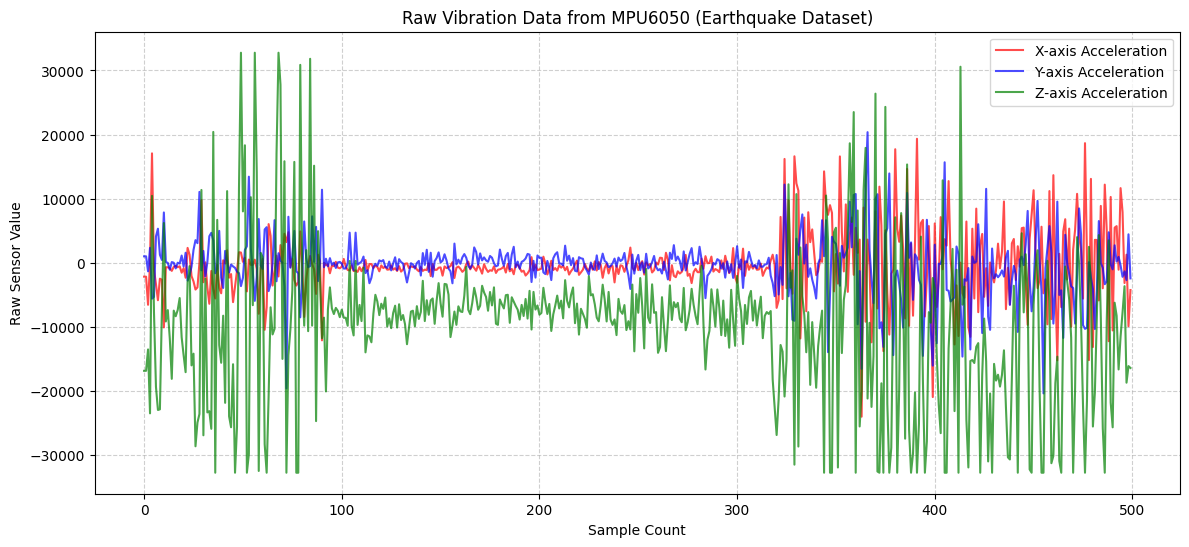

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load your dataset
df = pd.read_csv('earthquake_data.csv') # Make sure the filename is correct

# 2. Inspect the data
print(df.head())

plt.figure(figsize=(14, 6))

# We plot the first 500 rows to see the vibration pattern
plt.plot(df['aX'].iloc[0:500], label='X-axis Acceleration', color='red', alpha=0.7)
plt.plot(df['aY'].iloc[0:500], label='Y-axis Acceleration', color='blue', alpha=0.7)
plt.plot(df['aZ'].iloc[0:500], label='Z-axis Acceleration', color='green', alpha=0.7)

plt.title("Raw Vibration Data from MPU6050 (Earthquake Dataset)")
plt.xlabel("Sample Count")
plt.ylabel("Raw Sensor Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [2]:
def extract_features(window):
    features = []
    for col in ['aX', 'aY', 'aZ']:
        features.append(window[col].mean())
        features.append(window[col].std())
        features.append(window[col].max() - window[col].min()) # Peak-to-Peak (Range)
    return features

# Test it on a small window of 100 rows
sample_window = df.iloc[0:100]
test_features = extract_features(sample_window)
print("Successfully extracted features:", test_features)

Successfully extracted features: [-1201.08, 3811.5208600062288, 29176, 485.04, 4159.62098584217, 33028, -8114.55, 16803.27163212359, 65535]


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 1. load and define your data
df = pd.read_csv('earthquake_data.csv')
X = df[['aX', 'aY', 'aZ', 'gX', 'gY', 'gMZ']].values
y = df['Result'].values

# 2. Apply Scaling (Mandatory for Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. perform the Split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# 4. Initialize and Train the model
baseline_model = LogisticRegression(max_iter=1000, solver='lbfgs')
baseline_model.fit(X_train_lr, y_train_lr)

# 5. Evaluate the model
y_pred_lr = baseline_model.predict(X_test_lr)

print(f"--- Baseline Model (Logistic Regression) Metrics ---")
print(f"Accuracy: {accuracy_score(y_test_lr, y_pred_lr) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test_lr, y_pred_lr))

--- Baseline Model (Logistic Regression) Metrics ---
Accuracy: 83.10%

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      8646
           1       0.85      0.81      0.83      9137

    accuracy                           0.83     17783
   macro avg       0.83      0.83      0.83     17783
weighted avg       0.83      0.83      0.83     17783



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Use the RAW data (X), not the 'X_scaled' we used for the Neural Network.
# Random Forests work much better with the original unscaled numbers.
X_raw = df[['aX', 'aY', 'aZ', 'gX', 'gY', 'gMZ']]
y = df['Result']

# 2. Split again using the raw X
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)

# 3. Train the model with specific parameters to prevent 'laziness'
clf_fix = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15,       # Allow the trees to grow deeper to find patterns
    min_samples_split=5, 
    random_state=42,
    class_weight='balanced' # This forces the model to pay attention to both classes
)

clf_fix.fit(X_train_raw, y_train)

# 4. Re-evaluate
y_pred_fix = clf_fix.predict(X_test_raw)
print(f"Fixed Accuracy: {accuracy_score(y_test, y_pred_fix) * 100:.2f}%")
print(classification_report(y_test, y_pred_fix))

Fixed Accuracy: 99.94%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8646
           1       1.00      1.00      1.00      9137

    accuracy                           1.00     17783
   macro avg       1.00      1.00      1.00     17783
weighted avg       1.00      1.00      1.00     17783



In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 1. Load Data
df = pd.read_csv('earthquake_data.csv')

# 2. Select Features (X) and Label (y)
X = df[['aX', 'aY', 'aZ', 'gX', 'gY', 'gMZ']].values
y = df['Result'].values

# 3. Scaling (CRITICAL for Neural Networks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [12]:
# 1. Define the Architecture
model = Sequential([
    Dense(16, activation='relu', input_shape=(6,)), # Input layer (6 features)
    Dropout(0.2),                                   # Prevents overfitting
    Dense(8, activation='relu'),                    # Hidden layer
    Dense(1, activation='sigmoid')                  # Output layer (0 to 1 probability)
])

# 2. Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Train the Model with EPOCHS
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
1038/1038 [==============================] - 5s 4ms/step - loss: 0.2501 - accuracy: 0.9201 - val_loss: 0.0442 - val_accuracy: 0.9902
Epoch 2/50
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0375 - accuracy: 0.9915 - val_loss: 0.0164 - val_accuracy: 0.9963
Epoch 3/50
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0190 - accuracy: 0.9952 - val_loss: 0.0084 - val_accuracy: 0.9975
Epoch 4/50
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0121 - accuracy: 0.9970 - val_loss: 0.0052 - val_accuracy: 0.9986
Epoch 5/50
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.0034 - val_accuracy: 0.9989
Epoch 6/50
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0063 - accuracy: 0.9984 - val_loss: 0.0025 - val_accuracy: 0.9992
Epoch 7/50
1038/1038 [==============================] - 3s 3ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.0018 - val_accuracy:

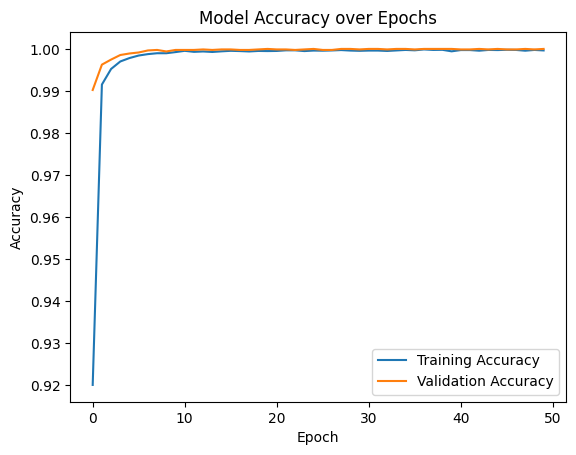

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

556/556 [==============================] - 1s 2ms/step
--- Final Evaluation Metrics ---
Overall Accuracy: 99.93%

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      8646
  Earthquake       1.00      1.00      1.00      9137

    accuracy                           1.00     17783
   macro avg       1.00      1.00      1.00     17783
weighted avg       1.00      1.00      1.00     17783



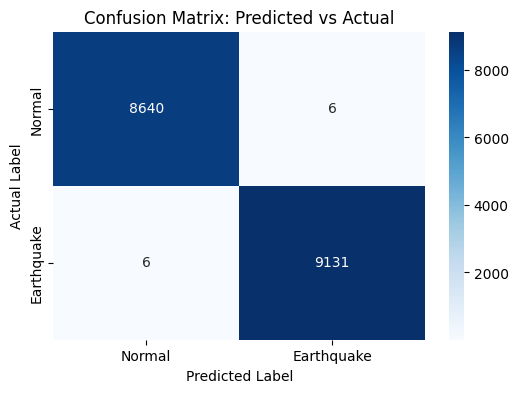

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get the model's predictions on the test data
# Since it's a 'sigmoid' output, values are between 0 and 1. 
# We convert them: > 0.5 is an earthquake (1), < 0.5 is normal (0)
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# 2. Generate the Evaluation Metrics
print("--- Final Evaluation Metrics ---")
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Earthquake']))

# 3. Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Earthquake'], yticklabels=['Normal', 'Earthquake'])
plt.title('Confusion Matrix: Predicted vs Actual')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

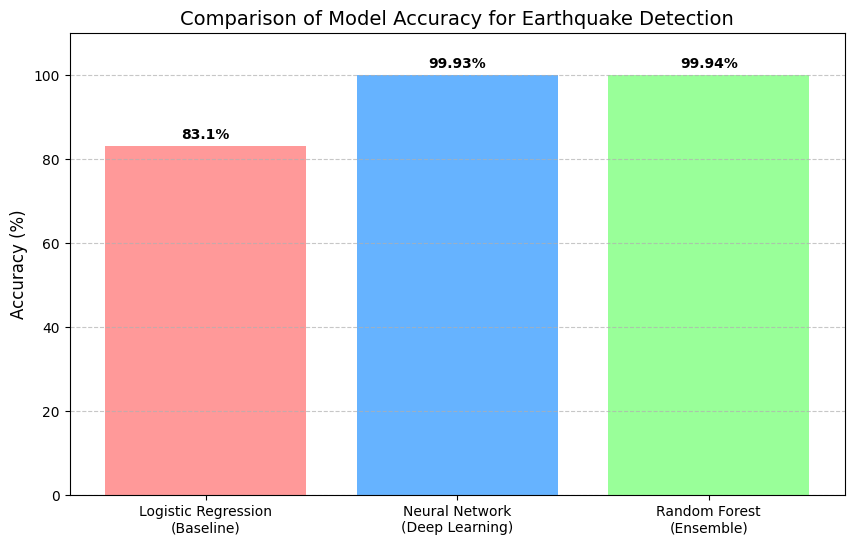

In [17]:
import matplotlib.pyplot as plt

model_names = ['Logistic Regression\n(Baseline)', 'Neural Network\n(Deep Learning)', 'Random Forest\n(Ensemble)']
accuracies = [83.10, 99.93, 99.94] 

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['#ff9999', '#66b3ff', '#99ff99'])

# Add labels and title
plt.title('Comparison of Model Accuracy for Earthquake Detection', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 110) # Set limit a bit higher to accommodate text labels

# Add the percentage values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()